# **Import libraries**

In [0]:
try:
    %tensorflow_version 2.x
except:
    pass

TensorFlow 2.x selected.


In [0]:
import numpy as np
import matplotlib.pylab as plt

import warnings 
def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
     warnings.simplefilter("ignore")
     fxn()
import pathlib
import tensorflow as tf
import tensorflow_datasets as tfds
# tfds.disable_progress_bar()
from tqdm import tqdm


# Import Dataset From Cloud
cat_vs_dog Dataset

In [0]:
splits = tfds.Split.ALL.subsplit(weighted=(80, 10, 10))

splits, info = tfds.load('cats_vs_dogs', with_info=True, as_supervised=True, split = splits)

(train_examples, validation_examples, test_examples) = splits

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

In [0]:
def format_image(image, label):
    image = tf.image.resize(image, IMAGE_SIZE) / 255.0
    return  image, label

In [0]:
BATCH_SIZE = 32 
IMAGE_SIZE = (150, 150)

In [0]:
train_batches = train_examples.shuffle(num_examples // 4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_examples.map(format_image).batch(BATCH_SIZE).prefetch(1)
test_batches = test_examples.map(format_image).batch(1)

In [0]:
for image_batch, label_batch in train_batches.take(1):
    pass

image_batch.shape

TensorShape([32, 150, 150, 3])

In [0]:
#drive mount(for upload model from drive)
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


#Convert model to TFlite


In [0]:
#load .h5 model
new_model = tf.keras.models.load_model('model_CD.h5')

In [0]:
#convert model
converter = tf.lite.TFLiteConverter.from_keras_model(new_model)
tflite_model = converter.convert()

In [0]:
tflite_model_file = pathlib.Path('converted_model.tflite')
tflite_model_file.write_bytes(tflite_model)

37981244

#Interpreter for tflite and test model

In [0]:
tflite_model_file = 'converted_model.tflite'
interpreter = tf.lite.Interpreter(model_path=tflite_model_file)
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

In [0]:
# Gather results for the randomly sampled test images
predictions = []

test_labels, test_imgs = [], []
for img, label in tqdm(test_batches.take(100)):
    interpreter.set_tensor(input_index, img)
    interpreter.invoke()
    predictions.append(interpreter.get_tensor(output_index))
    
    test_labels.append(label.numpy()[0])
    test_imgs.append(img)

100it [00:01, 67.29it/s]


In [0]:
class_names = ['cat', 'dog']

def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    img = np.squeeze(img)

    plt.imshow(img, cmap=plt.cm.binary)
    
    predicted_label = np.argmax(predictions_array)
    
    if predicted_label == true_label:
        color = 'green'
    else:
        color = 'red'
    
    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                         100*np.max(predictions_array),
                                         class_names[true_label]), color=color)

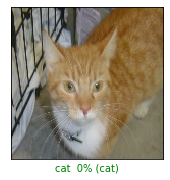

In [0]:
index = 1  #change index for testing models
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(index, predictions, test_labels, test_imgs)
plt.show()